# Assignment 1: Color Spaces, Morphological Operators

## Exercise 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put some example images in in /images.

Rough sketch:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)



In [108]:
from dataclasses import dataclass
from typing import Tuple, Union

import numpy as np


class RgbSubscriptable:
    def __getitem__(self, key):
        if key == 0:
            return self.r
        if key == 1:
            return self.g
        if key == 2:
            return self.b
        raise KeyError("Key must be an int and one of {0, 1, 2}.")
    
    def __str__(self):
        return f"<{self.__class__.__name__} r={self.r} g={self.g} b={self.b}>"


class Threshold(RgbSubscriptable):
    NONE = Threshold.uniform(0)
    
    def __init__(self, r, g, b):
        self.r = r
        self.g = g
        self.b = b
    
    @classmethod
    def uniform(cls, n):
        return cls(n, n, n)


class Color(RgbSubscriptable):
    def __init__(self, r, g, b, threshold=Threshold.NONE):
        self.r = r
        self.g = g
        self.b = b
        self.threshold = threshold


@dataclass
class ColorSpace:
    name: str
    colors: Tuple[Color]
    global_threshold: Threshold = Threshold.NONE
    RESULT: bool = False
    
    @classmethod
    def from_range(cls, r, g, b):
        means = (np.mean(r), np.mean(g), np.mean(b))
        return cls(
            colors=(
                Color(*means, threshold=Threshold(means[0] - r[0], means[1] - g[0], means[2] - b[0])),
            ),
        )
        
    def contains(self, check_color):
        return any(self._is_similar(own_color, check_color) for own_color in self.colors)
    
    def _is_similar(self, own_color, check_color):
        local_threshold = own_color.threshold
        global_threshold = self.global_threshold
        
        def comp_similar(i):
            comp_own = own_color[i]
            comp_check = check_color[i]
            thresh = local_threshold[i] + global_threshold[i]
            return comp_own - thresh <= comp_check <= comp_own + thresh
    
        return all(
            comp_similar(i) 
            for i in range(0, 3)
        ) 

    def __str__(self):
        colors = ', '.join(str(color) for color in self.colors)
        return f"<ColorSpace name='{self.name}' colors=({colors}) threshold={str(self.global_threshold)}>"

shape = (293, 277, 3)
blue, single color ...........
red, single color ...........
green, single color ...........
blue, multiple colors ...........
shape = (506, 760, 3)
hat, green + orange ...........


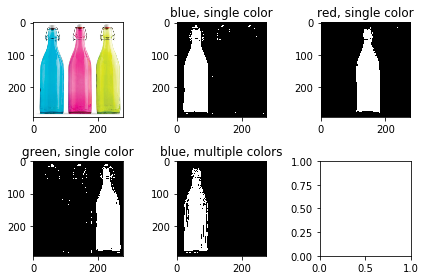

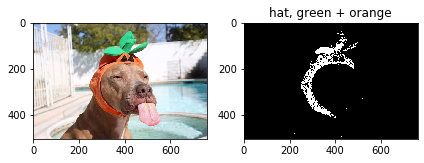

In [173]:
from skimage import io, data, color
import numpy as np


images = io.imread_collection('images/*')
RESULT = None


def handle_image(image, subspaces):
    if image.shape[2] == 4:
        # simply drop alpha channel
        image = image[:,:,:-1]
    
    shape = image.shape
    print('shape =', shape)
    
    linear_shape = (image.shape[0]*image.shape[1], 3)
    linear_image = image.reshape(linear_shape)
    ones = np.full(linear_shape[1:], 255)

    binarized_images = []
    for i, subspace in enumerate(subspaces):
        print(subspace.name, '...........')
        binarized_image = np.full(linear_shape, 0)

        for i, pixel in enumerate(linear_image):
            if subspace.contains(pixel):
                binarized_image[i] = ones
        binarized_image = binarized_image.reshape(shape)
        if subspace.RESULT:
            global RESULT
            RESULT = binarized_image
        binarized_images.append(binarized_image)
    fig = io.imshow_collection([image] + binarized_images)
    for subspace, ax in zip(("",) + subspaces, fig.axes):
        ax.set_title(getattr(subspace, 'name', subspace))
    fig.tight_layout()


colors = (
    # BOTTLES
    (
        # 1. single color for each bottle
        # bottle 1 (blueish)
        ColorSpace(
            name="blue, single color",
            colors=(
                Color(0, 179, 215, Threshold(200, 50, 50)),
            ),
        ),
        # bottle 2 (reddish)
        ColorSpace(
            name="red, single color",
            colors=(
                Color(236, 75, 155, Threshold(50, 100, 50)),
            ),
        ),
        # bottle 3 (greenish)
        ColorSpace(
            RESULT=True,
            name="green, single color",
            colors=(
                Color(207, 220, 39, Threshold(60, 60, 160)),
            ),
        ),
        
        # 2. more colors per bottle, smaller threshold
         # bottle 1
        ColorSpace(
            name="blue, multiple colors",
            colors=(
                Color(0, 183, 215),
                Color(0, 188, 220),
                Color(0, 178, 216),
                Color(107, 204, 228),
                Color(155, 216, 235),
                Color(1, 158, 188),
                Color(83, 198, 224),
                Color(1, 76, 88),
                Color(1, 177, 207),
                Color(0, 167, 203),
            ),
            global_threshold=Threshold.uniform(20),
        ),
        # picking colors for the other 2 bottles is no fun... :/
    ),


    # DOG
    (
        ColorSpace(
            name="hat, green + orange",
            colors=(
                # green
                Color(82, 236, 174),
                Color(23, 137, 79),
                Color(38, 176, 107),
                # orange
                Color(186, 45, 8),
                Color(89, 6, 0),
                Color(241, 122, 90),
                Color(248, 147, 103),
                Color(237, 91, 42),
                Color(188, 88, 49),
            ),
            global_threshold=Threshold(38, 38, 15),
        ),
    ),
)

i = -1
for image, subspaces in zip(images, colors):
    i += 1
#     if i != 1:
#         continue
    handle_image(image, subspaces)

# print('RESULT', RESULT)


## Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with the two-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

shape = (293, 277)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
1
left, top = 0 0 => 1 | 7 225
left, top = 0 0 => 2 | 8 140
left, top = 1 0 => 1 | 8 141
left, top = 1 0 => 1 | 8 142
left, top = 1 0 => 1 | 8 143
left, top = 1 0 => 1 | 8 144
left, top = 0 0 => 3 | 8 221
left, top = 1 0 => 1 | 8 222
left, top = 1 0 => 1 | 8 223
left, top = 1 0 => 1 | 8 224
left, top = 1 1 => 1 | 8 225
left, top = 1 0 => 1 | 8 226
left, top = 1 0 => 1 | 8 227
left, top = 1 0 => 1 | 8 228
left, top = 0 0 => 4 | 9 56
left, top = 1 0 => 1 | 9 57
left, top = 1 0 => 1 | 9 58
left, top = 1 0 => 1 | 9 59
left, top = 0 0 => 5 | 9 139
left, top = 1 1 => 1 | 9 140
left, top = 1 1 => 1 | 9 141
left, top = 1 1 => 1 | 9 142
left, top = 1 1 => 1 | 9 143
left, top = 1 1 => 1 | 9 144
left, top = 1 0 => 1 | 

left, top = 1 1 => 1 | 33 230
left, top = 1 1 => 1 | 33 231
left, top = 1 1 => 1 | 33 232
left, top = 1 1 => 1 | 33 233
left, top = 1 1 => 1 | 33 234
left, top = 0 1 => 1 | 34 215
left, top = 1 1 => 1 | 34 216
left, top = 1 1 => 1 | 34 217
left, top = 1 1 => 1 | 34 218
left, top = 1 1 => 1 | 34 219
left, top = 1 1 => 1 | 34 220
left, top = 1 1 => 1 | 34 221
left, top = 1 1 => 1 | 34 222
left, top = 1 1 => 1 | 34 223
left, top = 1 1 => 1 | 34 224
left, top = 1 1 => 1 | 34 225
left, top = 1 1 => 1 | 34 226
left, top = 1 1 => 1 | 34 227
left, top = 1 1 => 1 | 34 228
left, top = 1 1 => 1 | 34 229
left, top = 1 1 => 1 | 34 230
left, top = 1 1 => 1 | 34 231
left, top = 1 1 => 1 | 34 232
left, top = 1 1 => 1 | 34 233
left, top = 1 1 => 1 | 34 234
left, top = 1 0 => 1 | 34 235
left, top = 0 0 => 23 | 35 214
left, top = 1 1 => 1 | 35 215
left, top = 1 1 => 1 | 35 216
left, top = 1 1 => 1 | 35 217
left, top = 1 1 => 1 | 35 218
left, top = 1 1 => 1 | 35 219
left, top = 1 1 => 1 | 35 220
left, top

left, top = 1 1 => 1 | 52 217
left, top = 1 1 => 1 | 52 218
left, top = 1 1 => 1 | 52 219
left, top = 1 1 => 1 | 52 220
left, top = 1 1 => 1 | 52 221
left, top = 1 1 => 1 | 52 222
left, top = 1 1 => 1 | 52 223
left, top = 1 1 => 1 | 52 224
left, top = 1 1 => 1 | 52 225
left, top = 1 1 => 1 | 52 226
left, top = 1 1 => 1 | 52 227
left, top = 1 1 => 1 | 52 228
left, top = 1 1 => 1 | 52 229
left, top = 1 1 => 1 | 52 230
left, top = 1 1 => 1 | 52 231
left, top = 1 1 => 1 | 52 232
left, top = 1 1 => 1 | 52 233
left, top = 1 1 => 1 | 52 234
left, top = 1 1 => 1 | 52 235
left, top = 1 1 => 1 | 52 236
left, top = 1 0 => 1 | 52 237
left, top = 0 0 => 36 | 53 215
left, top = 1 1 => 1 | 53 216
left, top = 1 1 => 1 | 53 217
left, top = 1 1 => 1 | 53 218
left, top = 1 1 => 1 | 53 219
left, top = 1 1 => 1 | 53 220
left, top = 1 1 => 1 | 53 221
left, top = 1 1 => 1 | 53 222
left, top = 1 1 => 1 | 53 223
left, top = 0 1 => 1 | 53 235
left, top = 1 1 => 1 | 53 236
left, top = 0 1 => 1 | 54 216
left, top

left, top = 1 1 => 1 | 74 236
left, top = 1 1 => 1 | 74 237
left, top = 1 1 => 1 | 74 238
left, top = 1 1 => 1 | 74 239
left, top = 0 0 => 41 | 75 213
left, top = 1 1 => 1 | 75 214
left, top = 1 1 => 1 | 75 215
left, top = 1 1 => 1 | 75 216
left, top = 1 1 => 1 | 75 217
left, top = 1 1 => 1 | 75 218
left, top = 1 1 => 1 | 75 219
left, top = 1 1 => 1 | 75 220
left, top = 1 1 => 1 | 75 221
left, top = 1 1 => 1 | 75 222
left, top = 1 1 => 1 | 75 223
left, top = 1 1 => 1 | 75 224
left, top = 1 1 => 1 | 75 225
left, top = 1 1 => 1 | 75 226
left, top = 1 1 => 1 | 75 227
left, top = 1 1 => 1 | 75 228
left, top = 1 1 => 1 | 75 229
left, top = 1 1 => 1 | 75 230
left, top = 1 1 => 1 | 75 231
left, top = 1 1 => 1 | 75 232
left, top = 1 1 => 1 | 75 233
left, top = 1 1 => 1 | 75 234
left, top = 1 1 => 1 | 75 235
left, top = 1 1 => 1 | 75 236
left, top = 1 1 => 1 | 75 237
left, top = 1 1 => 1 | 75 238
left, top = 1 1 => 1 | 75 239
left, top = 0 1 => 1 | 76 213
left, top = 1 1 => 1 | 76 214
left, top

left, top = 1 1 => 1 | 87 227
left, top = 1 1 => 1 | 87 228
left, top = 1 1 => 1 | 87 229
left, top = 1 1 => 1 | 87 230
left, top = 1 1 => 1 | 87 231
left, top = 1 1 => 1 | 87 232
left, top = 1 1 => 1 | 87 233
left, top = 1 1 => 1 | 87 234
left, top = 1 1 => 1 | 87 235
left, top = 1 1 => 1 | 87 236
left, top = 1 1 => 1 | 87 237
left, top = 1 1 => 1 | 87 238
left, top = 1 1 => 1 | 87 239
left, top = 1 1 => 1 | 87 240
left, top = 1 1 => 1 | 87 241
left, top = 1 1 => 1 | 87 242
left, top = 1 0 => 1 | 87 243
left, top = 0 0 => 45 | 88 209
left, top = 1 1 => 1 | 88 210
left, top = 1 1 => 1 | 88 211
left, top = 1 1 => 1 | 88 212
left, top = 1 1 => 1 | 88 213
left, top = 1 1 => 1 | 88 214
left, top = 1 1 => 1 | 88 215
left, top = 1 1 => 1 | 88 216
left, top = 1 1 => 1 | 88 217
left, top = 1 1 => 1 | 88 218
left, top = 1 1 => 1 | 88 219
left, top = 1 1 => 1 | 88 220
left, top = 1 1 => 1 | 88 221
left, top = 1 1 => 1 | 88 222
left, top = 1 1 => 1 | 88 223
left, top = 1 1 => 1 | 88 224
left, top

left, top = 1 1 => 1 | 95 239
left, top = 1 1 => 1 | 95 240
left, top = 1 1 => 1 | 95 241
left, top = 1 1 => 1 | 95 242
left, top = 1 1 => 1 | 95 243
left, top = 1 1 => 1 | 95 244
left, top = 1 1 => 1 | 95 245
left, top = 1 1 => 1 | 95 246
left, top = 1 1 => 1 | 95 247
left, top = 0 0 => 48 | 96 206
left, top = 1 1 => 1 | 96 207
left, top = 1 1 => 1 | 96 208
left, top = 1 1 => 1 | 96 209
left, top = 1 1 => 1 | 96 210
left, top = 1 1 => 1 | 96 211
left, top = 1 1 => 1 | 96 212
left, top = 1 1 => 1 | 96 213
left, top = 1 1 => 1 | 96 214
left, top = 1 1 => 1 | 96 215
left, top = 1 1 => 1 | 96 216
left, top = 1 1 => 1 | 96 217
left, top = 1 1 => 1 | 96 218
left, top = 1 1 => 1 | 96 219
left, top = 1 1 => 1 | 96 220
left, top = 1 1 => 1 | 96 221
left, top = 1 1 => 1 | 96 222
left, top = 1 1 => 1 | 96 223
left, top = 1 1 => 1 | 96 224
left, top = 1 1 => 1 | 96 225
left, top = 1 1 => 1 | 96 226
left, top = 1 1 => 1 | 96 227
left, top = 1 1 => 1 | 96 228
left, top = 1 1 => 1 | 96 229
left, top

left, top = 1 1 => 1 | 104 239
left, top = 1 1 => 1 | 104 240
left, top = 1 1 => 1 | 104 241
left, top = 1 1 => 1 | 104 242
left, top = 1 1 => 1 | 104 243
left, top = 1 1 => 1 | 104 244
left, top = 1 1 => 1 | 104 245
left, top = 1 1 => 1 | 104 246
left, top = 1 1 => 1 | 104 247
left, top = 1 1 => 1 | 104 248
left, top = 1 1 => 1 | 104 249
left, top = 1 1 => 1 | 104 250
left, top = 1 1 => 1 | 104 251
left, top = 1 1 => 1 | 104 252
left, top = 1 1 => 1 | 104 253
left, top = 1 1 => 1 | 104 254
left, top = 1 1 => 1 | 104 255
left, top = 1 1 => 1 | 104 256
left, top = 0 1 => 1 | 105 204
left, top = 1 1 => 1 | 105 205
left, top = 1 1 => 1 | 105 206
left, top = 1 1 => 1 | 105 207
left, top = 1 1 => 1 | 105 208
left, top = 1 1 => 1 | 105 209
left, top = 1 1 => 1 | 105 210
left, top = 1 1 => 1 | 105 211
left, top = 1 1 => 1 | 105 212
left, top = 1 1 => 1 | 105 213
left, top = 1 1 => 1 | 105 214
left, top = 1 1 => 1 | 105 215
left, top = 1 1 => 1 | 105 216
left, top = 1 1 => 1 | 105 217
left, to

left, top = 1 1 => 1 | 110 216
left, top = 1 1 => 1 | 110 217
left, top = 1 1 => 1 | 110 218
left, top = 1 1 => 1 | 110 219
left, top = 1 1 => 1 | 110 220
left, top = 1 1 => 1 | 110 221
left, top = 1 1 => 1 | 110 222
left, top = 1 1 => 1 | 110 223
left, top = 1 1 => 1 | 110 224
left, top = 1 1 => 1 | 110 225
left, top = 1 1 => 1 | 110 226
left, top = 1 1 => 1 | 110 227
left, top = 1 1 => 1 | 110 228
left, top = 1 1 => 1 | 110 229
left, top = 1 1 => 1 | 110 230
left, top = 1 1 => 1 | 110 231
left, top = 1 1 => 1 | 110 232
left, top = 1 1 => 1 | 110 233
left, top = 1 1 => 1 | 110 234
left, top = 1 1 => 1 | 110 235
left, top = 1 1 => 1 | 110 236
left, top = 1 1 => 1 | 110 237
left, top = 1 1 => 1 | 110 238
left, top = 1 1 => 1 | 110 239
left, top = 1 1 => 1 | 110 240
left, top = 1 1 => 1 | 110 241
left, top = 1 1 => 1 | 110 242
left, top = 1 1 => 1 | 110 243
left, top = 1 1 => 1 | 110 244
left, top = 1 1 => 1 | 110 245
left, top = 1 1 => 1 | 110 246
left, top = 1 1 => 1 | 110 247
left, to

left, top = 1 1 => 1 | 119 230
left, top = 1 1 => 1 | 119 231
left, top = 1 1 => 1 | 119 232
left, top = 1 1 => 1 | 119 233
left, top = 1 1 => 1 | 119 234
left, top = 1 1 => 1 | 119 235
left, top = 1 1 => 1 | 119 236
left, top = 1 1 => 1 | 119 237
left, top = 1 1 => 1 | 119 238
left, top = 1 1 => 1 | 119 239
left, top = 1 1 => 1 | 119 240
left, top = 1 1 => 1 | 119 241
left, top = 1 1 => 1 | 119 242
left, top = 1 1 => 1 | 119 243
left, top = 1 1 => 1 | 119 244
left, top = 1 1 => 1 | 119 245
left, top = 1 1 => 1 | 119 246
left, top = 1 1 => 1 | 119 247
left, top = 1 1 => 1 | 119 248
left, top = 1 1 => 1 | 119 249
left, top = 1 1 => 1 | 119 250
left, top = 1 1 => 1 | 119 251
left, top = 1 1 => 1 | 119 252
left, top = 1 1 => 1 | 119 253
left, top = 1 1 => 1 | 119 254
left, top = 1 1 => 1 | 119 255
left, top = 1 1 => 1 | 119 256
left, top = 1 1 => 1 | 119 257
left, top = 1 1 => 1 | 119 258
left, top = 1 1 => 1 | 119 259
left, top = 0 0 => 61 | 119 261
left, top = 0 1 => 1 | 120 197
left, t

left, top = 1 1 => 1 | 127 234
left, top = 1 1 => 1 | 127 235
left, top = 1 1 => 1 | 127 236
left, top = 1 1 => 1 | 127 237
left, top = 1 1 => 1 | 127 238
left, top = 1 1 => 1 | 127 239
left, top = 1 1 => 1 | 127 240
left, top = 1 1 => 1 | 127 241
left, top = 1 1 => 1 | 127 242
left, top = 1 1 => 1 | 127 243
left, top = 1 1 => 1 | 127 244
left, top = 1 1 => 1 | 127 245
left, top = 1 1 => 1 | 127 246
left, top = 1 1 => 1 | 127 247
left, top = 1 1 => 1 | 127 248
left, top = 1 1 => 1 | 127 249
left, top = 1 1 => 1 | 127 250
left, top = 1 1 => 1 | 127 251
left, top = 1 1 => 1 | 127 252
left, top = 1 1 => 1 | 127 253
left, top = 1 1 => 1 | 127 254
left, top = 0 1 => 1 | 127 259
left, top = 1 1 => 1 | 127 260
left, top = 1 1 => 1 | 127 261
left, top = 0 1 => 1 | 127 263
left, top = 1 1 => 1 | 127 264
left, top = 0 1 => 1 | 128 195
left, top = 1 1 => 1 | 128 196
left, top = 1 1 => 1 | 128 197
left, top = 1 1 => 1 | 128 198
left, top = 1 1 => 1 | 128 199
left, top = 1 1 => 1 | 128 200
left, to

left, top = 1 1 => 1 | 135 212
left, top = 1 1 => 1 | 135 213
left, top = 1 1 => 1 | 135 214
left, top = 1 1 => 1 | 135 215
left, top = 1 1 => 1 | 135 216
left, top = 1 1 => 1 | 135 217
left, top = 1 1 => 1 | 135 218
left, top = 1 1 => 1 | 135 219
left, top = 1 1 => 1 | 135 220
left, top = 1 1 => 1 | 135 221
left, top = 1 1 => 1 | 135 222
left, top = 1 1 => 1 | 135 223
left, top = 1 1 => 1 | 135 224
left, top = 1 1 => 1 | 135 225
left, top = 1 1 => 1 | 135 226
left, top = 1 1 => 1 | 135 227
left, top = 1 1 => 1 | 135 228
left, top = 1 1 => 1 | 135 229
left, top = 1 1 => 1 | 135 230
left, top = 1 1 => 1 | 135 231
left, top = 1 1 => 1 | 135 232
left, top = 1 1 => 1 | 135 233
left, top = 1 1 => 1 | 135 234
left, top = 1 1 => 1 | 135 235
left, top = 1 1 => 1 | 135 236
left, top = 1 1 => 1 | 135 237
left, top = 1 1 => 1 | 135 238
left, top = 1 1 => 1 | 135 239
left, top = 1 1 => 1 | 135 240
left, top = 1 1 => 1 | 135 241
left, top = 1 1 => 1 | 135 242
left, top = 1 1 => 1 | 135 243
left, to

left, top = 1 1 => 1 | 142 208
left, top = 1 1 => 1 | 142 209
left, top = 1 1 => 1 | 142 210
left, top = 1 1 => 1 | 142 211
left, top = 1 1 => 1 | 142 212
left, top = 1 1 => 1 | 142 213
left, top = 1 1 => 1 | 142 214
left, top = 1 1 => 1 | 142 215
left, top = 1 1 => 1 | 142 216
left, top = 1 1 => 1 | 142 217
left, top = 1 1 => 1 | 142 218
left, top = 1 1 => 1 | 142 219
left, top = 1 1 => 1 | 142 220
left, top = 1 1 => 1 | 142 221
left, top = 1 1 => 1 | 142 222
left, top = 1 1 => 1 | 142 223
left, top = 1 1 => 1 | 142 224
left, top = 1 1 => 1 | 142 225
left, top = 1 1 => 1 | 142 226
left, top = 1 1 => 1 | 142 227
left, top = 1 1 => 1 | 142 228
left, top = 1 1 => 1 | 142 229
left, top = 1 1 => 1 | 142 230
left, top = 1 1 => 1 | 142 231
left, top = 1 1 => 1 | 142 232
left, top = 1 1 => 1 | 142 233
left, top = 1 1 => 1 | 142 234
left, top = 1 1 => 1 | 142 235
left, top = 1 1 => 1 | 142 236
left, top = 1 1 => 1 | 142 237
left, top = 1 1 => 1 | 142 238
left, top = 1 1 => 1 | 142 239
left, to

left, top = 1 1 => 1 | 148 208
left, top = 1 1 => 1 | 148 209
left, top = 1 1 => 1 | 148 210
left, top = 1 1 => 1 | 148 211
left, top = 1 1 => 1 | 148 212
left, top = 1 1 => 1 | 148 213
left, top = 1 1 => 1 | 148 214
left, top = 1 1 => 1 | 148 215
left, top = 1 1 => 1 | 148 216
left, top = 1 1 => 1 | 148 217
left, top = 1 1 => 1 | 148 218
left, top = 1 1 => 1 | 148 219
left, top = 1 1 => 1 | 148 220
left, top = 1 1 => 1 | 148 221
left, top = 1 1 => 1 | 148 222
left, top = 1 1 => 1 | 148 223
left, top = 1 1 => 1 | 148 224
left, top = 1 1 => 1 | 148 225
left, top = 1 1 => 1 | 148 226
left, top = 1 1 => 1 | 148 227
left, top = 1 1 => 1 | 148 228
left, top = 1 1 => 1 | 148 229
left, top = 1 1 => 1 | 148 230
left, top = 1 1 => 1 | 148 231
left, top = 1 1 => 1 | 148 232
left, top = 1 1 => 1 | 148 233
left, top = 1 1 => 1 | 148 234
left, top = 1 1 => 1 | 148 235
left, top = 1 1 => 1 | 148 236
left, top = 1 1 => 1 | 148 237
left, top = 1 1 => 1 | 148 238
left, top = 1 1 => 1 | 148 239
left, to

left, top = 1 1 => 1 | 154 203
left, top = 1 1 => 1 | 154 204
left, top = 1 1 => 1 | 154 205
left, top = 1 1 => 1 | 154 206
left, top = 1 1 => 1 | 154 207
left, top = 1 1 => 1 | 154 208
left, top = 1 1 => 1 | 154 209
left, top = 1 1 => 1 | 154 210
left, top = 1 1 => 1 | 154 211
left, top = 1 1 => 1 | 154 212
left, top = 1 1 => 1 | 154 213
left, top = 1 1 => 1 | 154 214
left, top = 1 1 => 1 | 154 215
left, top = 1 1 => 1 | 154 216
left, top = 1 1 => 1 | 154 217
left, top = 1 1 => 1 | 154 218
left, top = 1 1 => 1 | 154 219
left, top = 1 1 => 1 | 154 220
left, top = 1 1 => 1 | 154 221
left, top = 1 1 => 1 | 154 222
left, top = 1 1 => 1 | 154 223
left, top = 1 1 => 1 | 154 224
left, top = 1 1 => 1 | 154 225
left, top = 1 1 => 1 | 154 226
left, top = 1 1 => 1 | 154 227
left, top = 1 1 => 1 | 154 228
left, top = 1 1 => 1 | 154 229
left, top = 1 1 => 1 | 154 230
left, top = 1 1 => 1 | 154 231
left, top = 1 1 => 1 | 154 232
left, top = 1 1 => 1 | 154 233
left, top = 1 1 => 1 | 154 234
left, to

left, top = 1 1 => 1 | 158 220
left, top = 1 1 => 1 | 158 221
left, top = 1 1 => 1 | 158 222
left, top = 1 1 => 1 | 158 223
left, top = 1 1 => 1 | 158 224
left, top = 1 1 => 1 | 158 225
left, top = 1 1 => 1 | 158 226
left, top = 1 1 => 1 | 158 227
left, top = 1 1 => 1 | 158 228
left, top = 1 1 => 1 | 158 229
left, top = 1 1 => 1 | 158 230
left, top = 1 1 => 1 | 158 231
left, top = 1 1 => 1 | 158 232
left, top = 1 1 => 1 | 158 233
left, top = 1 1 => 1 | 158 234
left, top = 1 1 => 1 | 158 235
left, top = 1 1 => 1 | 158 236
left, top = 1 1 => 1 | 158 237
left, top = 1 1 => 1 | 158 238
left, top = 1 1 => 1 | 158 239
left, top = 1 1 => 1 | 158 240
left, top = 1 1 => 1 | 158 241
left, top = 1 1 => 1 | 158 242
left, top = 1 1 => 1 | 158 243
left, top = 1 1 => 1 | 158 244
left, top = 1 1 => 1 | 158 245
left, top = 1 1 => 1 | 158 246
left, top = 1 1 => 1 | 158 247
left, top = 1 1 => 1 | 158 248
left, top = 1 1 => 1 | 158 249
left, top = 1 1 => 1 | 158 250
left, top = 1 1 => 1 | 158 251
left, to

left, top = 1 1 => 1 | 165 219
left, top = 1 1 => 1 | 165 220
left, top = 1 1 => 1 | 165 221
left, top = 1 1 => 1 | 165 222
left, top = 1 1 => 1 | 165 223
left, top = 1 1 => 1 | 165 224
left, top = 1 1 => 1 | 165 225
left, top = 1 1 => 1 | 165 226
left, top = 1 1 => 1 | 165 227
left, top = 1 1 => 1 | 165 228
left, top = 1 1 => 1 | 165 229
left, top = 1 1 => 1 | 165 230
left, top = 1 1 => 1 | 165 231
left, top = 1 1 => 1 | 165 232
left, top = 1 1 => 1 | 165 233
left, top = 1 1 => 1 | 165 234
left, top = 1 1 => 1 | 165 235
left, top = 1 1 => 1 | 165 236
left, top = 1 1 => 1 | 165 237
left, top = 1 1 => 1 | 165 238
left, top = 1 1 => 1 | 165 239
left, top = 1 1 => 1 | 165 240
left, top = 1 1 => 1 | 165 241
left, top = 1 1 => 1 | 165 242
left, top = 1 1 => 1 | 165 243
left, top = 1 1 => 1 | 165 244
left, top = 1 1 => 1 | 165 245
left, top = 1 1 => 1 | 165 246
left, top = 1 1 => 1 | 165 247
left, top = 1 1 => 1 | 165 248
left, top = 1 1 => 1 | 165 249
left, top = 1 1 => 1 | 165 250
left, to

left, top = 1 1 => 1 | 169 248
left, top = 1 1 => 1 | 169 249
left, top = 1 1 => 1 | 169 250
left, top = 1 1 => 1 | 169 251
left, top = 1 1 => 1 | 169 252
left, top = 1 1 => 1 | 169 253
left, top = 1 1 => 1 | 169 254
left, top = 1 1 => 1 | 169 255
left, top = 1 1 => 1 | 169 256
left, top = 1 1 => 1 | 169 257
left, top = 1 1 => 1 | 169 258
left, top = 1 1 => 1 | 169 259
left, top = 1 1 => 1 | 169 260
left, top = 1 1 => 1 | 169 261
left, top = 1 1 => 1 | 169 262
left, top = 1 1 => 1 | 169 263
left, top = 1 1 => 1 | 169 264
left, top = 1 1 => 1 | 169 265
left, top = 1 1 => 1 | 169 266
left, top = 1 1 => 1 | 169 267
left, top = 0 1 => 1 | 170 197
left, top = 1 1 => 1 | 170 198
left, top = 1 1 => 1 | 170 199
left, top = 1 1 => 1 | 170 200
left, top = 1 1 => 1 | 170 201
left, top = 1 1 => 1 | 170 202
left, top = 1 1 => 1 | 170 203
left, top = 1 1 => 1 | 170 204
left, top = 1 1 => 1 | 170 205
left, top = 1 1 => 1 | 170 206
left, top = 1 1 => 1 | 170 207
left, top = 1 1 => 1 | 170 208
left, to

left, top = 1 1 => 1 | 174 205
left, top = 1 1 => 1 | 174 206
left, top = 1 1 => 1 | 174 207
left, top = 1 1 => 1 | 174 208
left, top = 1 1 => 1 | 174 209
left, top = 1 1 => 1 | 174 210
left, top = 1 1 => 1 | 174 211
left, top = 1 1 => 1 | 174 212
left, top = 1 1 => 1 | 174 213
left, top = 1 1 => 1 | 174 214
left, top = 1 1 => 1 | 174 215
left, top = 1 1 => 1 | 174 216
left, top = 1 1 => 1 | 174 217
left, top = 1 1 => 1 | 174 218
left, top = 1 1 => 1 | 174 219
left, top = 1 1 => 1 | 174 220
left, top = 1 1 => 1 | 174 221
left, top = 1 1 => 1 | 174 222
left, top = 1 1 => 1 | 174 223
left, top = 1 1 => 1 | 174 224
left, top = 1 1 => 1 | 174 225
left, top = 1 1 => 1 | 174 226
left, top = 1 1 => 1 | 174 227
left, top = 1 1 => 1 | 174 228
left, top = 1 1 => 1 | 174 229
left, top = 1 1 => 1 | 174 230
left, top = 1 1 => 1 | 174 231
left, top = 1 1 => 1 | 174 232
left, top = 1 1 => 1 | 174 233
left, top = 1 1 => 1 | 174 234
left, top = 1 1 => 1 | 174 235
left, top = 1 1 => 1 | 174 236
left, to

left, top = 1 1 => 1 | 178 234
left, top = 1 1 => 1 | 178 235
left, top = 1 1 => 1 | 178 236
left, top = 1 1 => 1 | 178 237
left, top = 1 1 => 1 | 178 238
left, top = 1 1 => 1 | 178 239
left, top = 1 1 => 1 | 178 240
left, top = 1 1 => 1 | 178 241
left, top = 1 1 => 1 | 178 242
left, top = 1 1 => 1 | 178 243
left, top = 1 1 => 1 | 178 244
left, top = 1 1 => 1 | 178 245
left, top = 1 1 => 1 | 178 246
left, top = 1 1 => 1 | 178 247
left, top = 1 1 => 1 | 178 248
left, top = 1 1 => 1 | 178 249
left, top = 1 1 => 1 | 178 250
left, top = 1 1 => 1 | 178 251
left, top = 1 1 => 1 | 178 252
left, top = 1 1 => 1 | 178 253
left, top = 1 1 => 1 | 178 254
left, top = 1 1 => 1 | 178 255
left, top = 1 1 => 1 | 178 256
left, top = 1 1 => 1 | 178 257
left, top = 1 1 => 1 | 178 258
left, top = 1 1 => 1 | 178 259
left, top = 1 1 => 1 | 178 260
left, top = 1 1 => 1 | 178 261
left, top = 1 1 => 1 | 178 262
left, top = 1 1 => 1 | 178 263
left, top = 1 1 => 1 | 178 264
left, top = 1 1 => 1 | 178 265
left, to

left, top = 1 1 => 1 | 182 265
left, top = 1 1 => 1 | 182 266
left, top = 1 1 => 1 | 182 267
left, top = 0 1 => 1 | 183 198
left, top = 1 1 => 1 | 183 199
left, top = 1 1 => 1 | 183 200
left, top = 1 1 => 1 | 183 201
left, top = 1 1 => 1 | 183 202
left, top = 1 1 => 1 | 183 203
left, top = 1 1 => 1 | 183 204
left, top = 1 1 => 1 | 183 205
left, top = 1 1 => 1 | 183 206
left, top = 1 1 => 1 | 183 207
left, top = 1 1 => 1 | 183 208
left, top = 1 1 => 1 | 183 209
left, top = 1 1 => 1 | 183 210
left, top = 1 1 => 1 | 183 211
left, top = 1 1 => 1 | 183 212
left, top = 1 1 => 1 | 183 213
left, top = 1 1 => 1 | 183 214
left, top = 1 1 => 1 | 183 215
left, top = 1 1 => 1 | 183 216
left, top = 1 1 => 1 | 183 217
left, top = 1 1 => 1 | 183 218
left, top = 1 1 => 1 | 183 219
left, top = 1 1 => 1 | 183 220
left, top = 1 1 => 1 | 183 221
left, top = 1 1 => 1 | 183 222
left, top = 1 1 => 1 | 183 223
left, top = 1 1 => 1 | 183 224
left, top = 1 1 => 1 | 183 225
left, top = 1 1 => 1 | 183 226
left, to

left, top = 1 1 => 1 | 189 255
left, top = 1 1 => 1 | 189 256
left, top = 1 1 => 1 | 189 257
left, top = 1 1 => 1 | 189 258
left, top = 1 1 => 1 | 189 259
left, top = 1 1 => 1 | 189 260
left, top = 1 1 => 1 | 189 261
left, top = 1 1 => 1 | 189 262
left, top = 1 1 => 1 | 189 263
left, top = 1 1 => 1 | 189 264
left, top = 1 1 => 1 | 189 265
left, top = 1 1 => 1 | 189 266
left, top = 1 1 => 1 | 189 267
left, top = 0 1 => 1 | 190 195
left, top = 1 1 => 1 | 190 196
left, top = 1 1 => 1 | 190 197
left, top = 1 1 => 1 | 190 198
left, top = 1 1 => 1 | 190 199
left, top = 1 1 => 1 | 190 200
left, top = 1 1 => 1 | 190 201
left, top = 1 1 => 1 | 190 202
left, top = 1 1 => 1 | 190 203
left, top = 1 1 => 1 | 190 204
left, top = 1 1 => 1 | 190 205
left, top = 1 1 => 1 | 190 206
left, top = 1 1 => 1 | 190 207
left, top = 1 1 => 1 | 190 208
left, top = 1 1 => 1 | 190 209
left, top = 1 1 => 1 | 190 210
left, top = 1 1 => 1 | 190 211
left, top = 1 1 => 1 | 190 212
left, top = 1 1 => 1 | 190 213
left, to

left, top = 1 1 => 1 | 195 260
left, top = 1 1 => 1 | 195 261
left, top = 1 1 => 1 | 195 262
left, top = 1 1 => 1 | 195 263
left, top = 1 1 => 1 | 195 264
left, top = 1 1 => 1 | 195 265
left, top = 1 1 => 1 | 195 266
left, top = 1 1 => 1 | 195 267
left, top = 1 1 => 1 | 195 268
left, top = 0 1 => 1 | 196 197
left, top = 1 1 => 1 | 196 198
left, top = 1 1 => 1 | 196 199
left, top = 1 1 => 1 | 196 200
left, top = 1 1 => 1 | 196 201
left, top = 1 1 => 1 | 196 202
left, top = 1 1 => 1 | 196 203
left, top = 1 1 => 1 | 196 204
left, top = 1 1 => 1 | 196 205
left, top = 1 1 => 1 | 196 206
left, top = 1 1 => 1 | 196 207
left, top = 1 1 => 1 | 196 208
left, top = 1 1 => 1 | 196 209
left, top = 1 1 => 1 | 196 210
left, top = 1 1 => 1 | 196 211
left, top = 1 1 => 1 | 196 212
left, top = 1 1 => 1 | 196 213
left, top = 1 1 => 1 | 196 214
left, top = 1 1 => 1 | 196 215
left, top = 1 1 => 1 | 196 216
left, top = 1 1 => 1 | 196 217
left, top = 1 1 => 1 | 196 218
left, top = 1 1 => 1 | 196 219
left, to

left, top = 1 1 => 1 | 202 252
left, top = 1 1 => 1 | 202 253
left, top = 1 1 => 1 | 202 254
left, top = 1 1 => 1 | 202 255
left, top = 1 1 => 1 | 202 256
left, top = 1 1 => 1 | 202 257
left, top = 1 1 => 1 | 202 258
left, top = 1 1 => 1 | 202 259
left, top = 1 1 => 1 | 202 260
left, top = 1 1 => 1 | 202 261
left, top = 1 1 => 1 | 202 262
left, top = 1 1 => 1 | 202 263
left, top = 1 1 => 1 | 202 264
left, top = 1 1 => 1 | 202 265
left, top = 1 1 => 1 | 202 266
left, top = 1 1 => 1 | 202 267
left, top = 1 1 => 1 | 202 268
left, top = 0 1 => 1 | 203 196
left, top = 1 1 => 1 | 203 197
left, top = 1 1 => 1 | 203 198
left, top = 1 1 => 1 | 203 199
left, top = 1 1 => 1 | 203 200
left, top = 1 1 => 1 | 203 201
left, top = 1 1 => 1 | 203 202
left, top = 1 1 => 1 | 203 203
left, top = 1 1 => 1 | 203 204
left, top = 1 1 => 1 | 203 205
left, top = 1 1 => 1 | 203 206
left, top = 1 1 => 1 | 203 207
left, top = 1 1 => 1 | 203 208
left, top = 1 1 => 1 | 203 209
left, top = 1 1 => 1 | 203 210
left, to

left, top = 1 1 => 1 | 209 230
left, top = 1 1 => 1 | 209 231
left, top = 1 1 => 1 | 209 232
left, top = 1 1 => 1 | 209 233
left, top = 1 1 => 1 | 209 234
left, top = 1 1 => 1 | 209 235
left, top = 1 1 => 1 | 209 236
left, top = 1 1 => 1 | 209 237
left, top = 1 1 => 1 | 209 238
left, top = 1 1 => 1 | 209 239
left, top = 1 1 => 1 | 209 240
left, top = 1 1 => 1 | 209 241
left, top = 1 1 => 1 | 209 242
left, top = 1 1 => 1 | 209 243
left, top = 1 1 => 1 | 209 244
left, top = 1 1 => 1 | 209 245
left, top = 1 1 => 1 | 209 246
left, top = 1 1 => 1 | 209 247
left, top = 1 1 => 1 | 209 248
left, top = 1 1 => 1 | 209 249
left, top = 1 1 => 1 | 209 250
left, top = 1 1 => 1 | 209 251
left, top = 1 1 => 1 | 209 252
left, top = 1 1 => 1 | 209 253
left, top = 1 1 => 1 | 209 254
left, top = 1 1 => 1 | 209 255
left, top = 1 1 => 1 | 209 256
left, top = 1 1 => 1 | 209 257
left, top = 1 1 => 1 | 209 258
left, top = 1 1 => 1 | 209 259
left, top = 1 1 => 1 | 209 260
left, top = 1 1 => 1 | 209 261
left, to

left, top = 1 1 => 1 | 215 218
left, top = 1 1 => 1 | 215 219
left, top = 1 1 => 1 | 215 220
left, top = 1 1 => 1 | 215 221
left, top = 1 1 => 1 | 215 222
left, top = 1 1 => 1 | 215 223
left, top = 1 1 => 1 | 215 224
left, top = 1 1 => 1 | 215 225
left, top = 1 1 => 1 | 215 226
left, top = 1 1 => 1 | 215 227
left, top = 1 1 => 1 | 215 228
left, top = 1 1 => 1 | 215 229
left, top = 1 1 => 1 | 215 230
left, top = 1 1 => 1 | 215 231
left, top = 1 1 => 1 | 215 232
left, top = 1 1 => 1 | 215 233
left, top = 1 1 => 1 | 215 234
left, top = 1 1 => 1 | 215 235
left, top = 1 1 => 1 | 215 236
left, top = 1 1 => 1 | 215 237
left, top = 1 1 => 1 | 215 238
left, top = 1 1 => 1 | 215 239
left, top = 1 1 => 1 | 215 240
left, top = 1 1 => 1 | 215 241
left, top = 1 1 => 1 | 215 242
left, top = 1 1 => 1 | 215 243
left, top = 1 1 => 1 | 215 244
left, top = 1 1 => 1 | 215 245
left, top = 1 1 => 1 | 215 246
left, top = 1 1 => 1 | 215 247
left, top = 1 1 => 1 | 215 248
left, top = 1 1 => 1 | 215 249
left, to

left, top = 1 1 => 1 | 220 259
left, top = 1 1 => 1 | 220 260
left, top = 1 1 => 1 | 220 261
left, top = 1 1 => 1 | 220 262
left, top = 1 1 => 1 | 220 263
left, top = 1 1 => 1 | 220 264
left, top = 1 1 => 1 | 220 265
left, top = 1 1 => 1 | 220 266
left, top = 1 1 => 1 | 220 267
left, top = 1 1 => 1 | 220 268
left, top = 0 1 => 1 | 221 194
left, top = 1 1 => 1 | 221 195
left, top = 1 1 => 1 | 221 196
left, top = 1 1 => 1 | 221 197
left, top = 1 1 => 1 | 221 198
left, top = 1 1 => 1 | 221 199
left, top = 1 1 => 1 | 221 200
left, top = 1 1 => 1 | 221 201
left, top = 1 1 => 1 | 221 202
left, top = 1 1 => 1 | 221 203
left, top = 1 1 => 1 | 221 204
left, top = 1 1 => 1 | 221 205
left, top = 1 1 => 1 | 221 206
left, top = 1 1 => 1 | 221 207
left, top = 1 1 => 1 | 221 208
left, top = 1 1 => 1 | 221 209
left, top = 1 1 => 1 | 221 210
left, top = 1 1 => 1 | 221 211
left, top = 1 1 => 1 | 221 212
left, top = 1 1 => 1 | 221 213
left, top = 1 1 => 1 | 221 214
left, top = 1 1 => 1 | 221 215
left, to

left, top = 1 1 => 1 | 226 267
left, top = 1 1 => 1 | 226 268
left, top = 0 1 => 1 | 227 194
left, top = 1 1 => 1 | 227 195
left, top = 1 1 => 1 | 227 196
left, top = 1 1 => 1 | 227 197
left, top = 1 1 => 1 | 227 198
left, top = 1 1 => 1 | 227 199
left, top = 1 1 => 1 | 227 200
left, top = 1 1 => 1 | 227 201
left, top = 1 1 => 1 | 227 202
left, top = 1 1 => 1 | 227 203
left, top = 1 1 => 1 | 227 204
left, top = 1 1 => 1 | 227 205
left, top = 1 1 => 1 | 227 206
left, top = 1 1 => 1 | 227 207
left, top = 1 1 => 1 | 227 208
left, top = 1 1 => 1 | 227 209
left, top = 1 1 => 1 | 227 210
left, top = 1 1 => 1 | 227 211
left, top = 1 1 => 1 | 227 212
left, top = 1 1 => 1 | 227 213
left, top = 1 1 => 1 | 227 214
left, top = 1 1 => 1 | 227 215
left, top = 1 1 => 1 | 227 216
left, top = 1 1 => 1 | 227 217
left, top = 1 1 => 1 | 227 218
left, top = 1 1 => 1 | 227 219
left, top = 1 1 => 1 | 227 220
left, top = 1 1 => 1 | 227 221
left, top = 1 1 => 1 | 227 222
left, top = 1 1 => 1 | 227 223
left, to

left, top = 1 1 => 1 | 232 261
left, top = 1 1 => 1 | 232 262
left, top = 1 1 => 1 | 232 263
left, top = 1 1 => 1 | 232 264
left, top = 1 1 => 1 | 232 265
left, top = 1 1 => 1 | 232 266
left, top = 1 1 => 1 | 232 267
left, top = 1 1 => 1 | 232 268
left, top = 0 1 => 1 | 233 194
left, top = 1 1 => 1 | 233 195
left, top = 1 1 => 1 | 233 196
left, top = 1 1 => 1 | 233 197
left, top = 1 1 => 1 | 233 198
left, top = 1 1 => 1 | 233 199
left, top = 1 1 => 1 | 233 200
left, top = 1 1 => 1 | 233 201
left, top = 1 1 => 1 | 233 202
left, top = 1 1 => 1 | 233 203
left, top = 1 1 => 1 | 233 204
left, top = 1 1 => 1 | 233 205
left, top = 1 1 => 1 | 233 206
left, top = 1 1 => 1 | 233 207
left, top = 1 1 => 1 | 233 208
left, top = 1 1 => 1 | 233 209
left, top = 1 1 => 1 | 233 210
left, top = 1 1 => 1 | 233 211
left, top = 1 1 => 1 | 233 212
left, top = 1 1 => 1 | 233 213
left, top = 1 1 => 1 | 233 214
left, top = 1 1 => 1 | 233 215
left, top = 1 1 => 1 | 233 216
left, top = 1 1 => 1 | 233 217
left, to

left, top = 1 1 => 1 | 240 217
left, top = 1 1 => 1 | 240 218
left, top = 1 1 => 1 | 240 219
left, top = 1 1 => 1 | 240 220
left, top = 1 1 => 1 | 240 221
left, top = 1 1 => 1 | 240 222
left, top = 1 1 => 1 | 240 223
left, top = 1 1 => 1 | 240 224
left, top = 1 1 => 1 | 240 225
left, top = 1 1 => 1 | 240 226
left, top = 1 1 => 1 | 240 227
left, top = 1 1 => 1 | 240 228
left, top = 1 1 => 1 | 240 229
left, top = 1 1 => 1 | 240 230
left, top = 1 1 => 1 | 240 231
left, top = 1 1 => 1 | 240 232
left, top = 1 1 => 1 | 240 233
left, top = 1 1 => 1 | 240 234
left, top = 1 1 => 1 | 240 235
left, top = 1 1 => 1 | 240 236
left, top = 1 1 => 1 | 240 237
left, top = 1 1 => 1 | 240 238
left, top = 1 1 => 1 | 240 239
left, top = 1 1 => 1 | 240 240
left, top = 1 1 => 1 | 240 241
left, top = 1 1 => 1 | 240 242
left, top = 1 1 => 1 | 240 243
left, top = 1 1 => 1 | 240 244
left, top = 1 1 => 1 | 240 245
left, top = 1 1 => 1 | 240 246
left, top = 1 1 => 1 | 240 247
left, top = 1 1 => 1 | 240 248
left, to

left, top = 1 1 => 1 | 246 215
left, top = 1 1 => 1 | 246 216
left, top = 1 1 => 1 | 246 217
left, top = 1 1 => 1 | 246 218
left, top = 1 1 => 1 | 246 219
left, top = 1 1 => 1 | 246 220
left, top = 1 1 => 1 | 246 221
left, top = 1 1 => 1 | 246 222
left, top = 1 1 => 1 | 246 223
left, top = 1 1 => 1 | 246 224
left, top = 1 1 => 1 | 246 225
left, top = 1 1 => 1 | 246 226
left, top = 1 1 => 1 | 246 227
left, top = 1 1 => 1 | 246 228
left, top = 1 1 => 1 | 246 229
left, top = 1 1 => 1 | 246 230
left, top = 1 1 => 1 | 246 231
left, top = 1 1 => 1 | 246 232
left, top = 1 1 => 1 | 246 233
left, top = 1 1 => 1 | 246 234
left, top = 1 1 => 1 | 246 235
left, top = 1 1 => 1 | 246 236
left, top = 1 1 => 1 | 246 237
left, top = 1 1 => 1 | 246 238
left, top = 1 1 => 1 | 246 239
left, top = 1 1 => 1 | 246 240
left, top = 1 1 => 1 | 246 241
left, top = 1 1 => 1 | 246 242
left, top = 1 1 => 1 | 246 243
left, top = 1 1 => 1 | 246 244
left, top = 1 1 => 1 | 246 245
left, top = 1 1 => 1 | 246 246
left, to

left, top = 1 1 => 1 | 252 226
left, top = 1 1 => 1 | 252 227
left, top = 1 1 => 1 | 252 228
left, top = 1 1 => 1 | 252 229
left, top = 1 1 => 1 | 252 230
left, top = 1 1 => 1 | 252 231
left, top = 1 1 => 1 | 252 232
left, top = 1 1 => 1 | 252 233
left, top = 1 1 => 1 | 252 234
left, top = 1 1 => 1 | 252 235
left, top = 1 1 => 1 | 252 236
left, top = 1 1 => 1 | 252 237
left, top = 1 1 => 1 | 252 238
left, top = 1 1 => 1 | 252 239
left, top = 1 1 => 1 | 252 240
left, top = 1 1 => 1 | 252 241
left, top = 1 1 => 1 | 252 242
left, top = 1 1 => 1 | 252 243
left, top = 1 1 => 1 | 252 244
left, top = 1 1 => 1 | 252 245
left, top = 1 1 => 1 | 252 246
left, top = 1 1 => 1 | 252 247
left, top = 1 1 => 1 | 252 248
left, top = 1 1 => 1 | 252 249
left, top = 1 1 => 1 | 252 250
left, top = 1 1 => 1 | 252 251
left, top = 1 1 => 1 | 252 252
left, top = 1 1 => 1 | 252 253
left, top = 1 1 => 1 | 252 254
left, top = 1 1 => 1 | 252 255
left, top = 1 1 => 1 | 252 256
left, top = 1 1 => 1 | 252 257
left, to

left, top = 1 1 => 1 | 260 217
left, top = 1 1 => 1 | 260 218
left, top = 1 1 => 1 | 260 219
left, top = 1 1 => 1 | 260 220
left, top = 1 1 => 1 | 260 221
left, top = 1 1 => 1 | 260 222
left, top = 1 1 => 1 | 260 223
left, top = 1 1 => 1 | 260 224
left, top = 1 1 => 1 | 260 225
left, top = 1 1 => 1 | 260 226
left, top = 1 1 => 1 | 260 227
left, top = 1 1 => 1 | 260 228
left, top = 1 1 => 1 | 260 229
left, top = 1 1 => 1 | 260 230
left, top = 1 1 => 1 | 260 231
left, top = 1 1 => 1 | 260 232
left, top = 1 1 => 1 | 260 233
left, top = 1 1 => 1 | 260 234
left, top = 1 1 => 1 | 260 235
left, top = 1 1 => 1 | 260 236
left, top = 1 1 => 1 | 260 237
left, top = 1 1 => 1 | 260 238
left, top = 1 1 => 1 | 260 239
left, top = 1 1 => 1 | 260 240
left, top = 1 1 => 1 | 260 241
left, top = 1 1 => 1 | 260 242
left, top = 1 1 => 1 | 260 243
left, top = 1 1 => 1 | 260 244
left, top = 1 1 => 1 | 260 245
left, top = 1 1 => 1 | 260 246
left, top = 1 1 => 1 | 260 247
left, top = 1 1 => 1 | 260 248
left, to

left, top = 1 1 => 1 | 265 217
left, top = 1 1 => 1 | 265 218
left, top = 1 1 => 1 | 265 219
left, top = 1 1 => 1 | 265 220
left, top = 1 1 => 1 | 265 221
left, top = 1 1 => 1 | 265 222
left, top = 1 1 => 1 | 265 223
left, top = 1 1 => 1 | 265 224
left, top = 1 1 => 1 | 265 225
left, top = 1 1 => 1 | 265 226
left, top = 1 1 => 1 | 265 227
left, top = 1 1 => 1 | 265 228
left, top = 1 1 => 1 | 265 229
left, top = 1 1 => 1 | 265 230
left, top = 1 1 => 1 | 265 231
left, top = 1 1 => 1 | 265 232
left, top = 1 1 => 1 | 265 233
left, top = 1 1 => 1 | 265 234
left, top = 1 1 => 1 | 265 235
left, top = 1 1 => 1 | 265 236
left, top = 1 1 => 1 | 265 237
left, top = 1 1 => 1 | 265 238
left, top = 1 1 => 1 | 265 239
left, top = 1 1 => 1 | 265 240
left, top = 1 1 => 1 | 265 241
left, top = 1 1 => 1 | 265 242
left, top = 1 1 => 1 | 265 243
left, top = 1 1 => 1 | 265 244
left, top = 1 1 => 1 | 265 245
left, top = 1 1 => 1 | 265 246
left, top = 1 1 => 1 | 265 247
left, top = 1 1 => 1 | 265 248
left, to

left, top = 1 1 => 1 | 271 223
left, top = 1 1 => 1 | 271 224
left, top = 1 1 => 1 | 271 225
left, top = 1 1 => 1 | 271 226
left, top = 1 1 => 1 | 271 227
left, top = 1 1 => 1 | 271 228
left, top = 1 1 => 1 | 271 229
left, top = 1 1 => 1 | 271 230
left, top = 1 1 => 1 | 271 231
left, top = 1 1 => 1 | 271 232
left, top = 1 1 => 1 | 271 233
left, top = 1 1 => 1 | 271 234
left, top = 1 1 => 1 | 271 235
left, top = 1 1 => 1 | 271 236
left, top = 1 1 => 1 | 271 237
left, top = 1 1 => 1 | 271 238
left, top = 1 1 => 1 | 271 239
left, top = 1 1 => 1 | 271 240
left, top = 1 0 => 1 | 271 241
left, top = 1 1 => 1 | 271 242
left, top = 1 1 => 1 | 271 243
left, top = 1 1 => 1 | 271 244
left, top = 1 1 => 1 | 271 245
left, top = 1 1 => 1 | 271 246
left, top = 1 1 => 1 | 271 247
left, top = 1 1 => 1 | 271 248
left, top = 1 1 => 1 | 271 249
left, top = 1 1 => 1 | 271 250
left, top = 1 1 => 1 | 271 251
left, top = 1 1 => 1 | 271 252
left, top = 1 1 => 1 | 271 253
left, top = 1 1 => 1 | 271 254
left, to

(None, None)

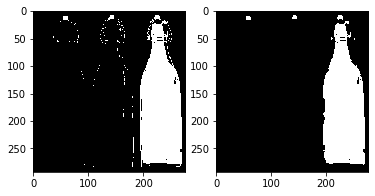

In [181]:
from skimage.morphology import binary_erosion, binary_dilation
from skimage.util import img_as_ubyte, img_as_uint, img_as_bool


def two_pass_alogrithm(image):    
    image = np.copy(image)
    print('shape =', image.shape)
    print(image)
#     i = np.bitwise_or.reduce(image, axis=2)
#     print('shape =', i.shape)
    print(i)
#     structuring_element = np.array()
    equivalency_list = {0: 0}
    
    def px2(pixel):
        return 
    
    def label_pixel(row, col):
        # nonlocal image
#         nonlocal equivalency_list
        
        pixel = image[row, col]
#         print(pixel, type(pixel))
        # background pixel => nothing of interest => nothing to do
        if not pixel:
#             print('bg', end='')
            return
        
#         print('')
        left = 0
        top = 0
        if col > 0:
            left = int(image[row, col - 1])
        if row > 0:
            top = int(image[row - 1, col])
        
        # new label
        if left == 0 and top == 0:
            label = max(equivalency_list.keys()) + 1
            equivalency_list[label] = label
        # special case: connect areas => adjust equivalency list
        elif left > 0 and top > 0:
            label = int(min(left, top))
            equivalency_list[max(left, top)] = label
        # extend area (either px is 0)
        else:
            label = int(max(left, top))
        
        print('left, top =', left, top, '=>', label, '|', row, col)
        
        image[row, col] = label
    
    rows, cols = image.shape[0:2]
    for row in range(rows):
        for col in range(cols):
            label_pixel(row, col)
    
    print(equivalency_list)
    print(image)

    connected_components = None
    bounding_box = None
    return connected_components, bounding_box

# RESULT = img_as_bool(io.imread("temp2.png"))[:,:,:-1]
# print(RESULT)
denoised = binary_dilation(binary_erosion(RESULT))
io.imshow_collection([RESULT, img_as_ubyte(denoised)])

# io.imsave("temp.png", img_as_ubyte(denoised))

denoised_2d = np.bitwise_or.reduce(denoised, axis=2)
two_pass_alogrithm(denoised_2d)


## Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)